In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from particle import PDGID
from particle import Particle
#import mplhep as hep
#hep.set_style('CMS')
#hep.style.use('CMS')


In [3]:
file = uproot.open('/vols/cms/emc21/idmStudy/MadGraph_files/distributions/h2h2lPlM_lem/BP3/h2h2lPlM_lem_BP3/Events/run_01/unweighted_events.root')
tree = file['LHEF']
tree = tree['Particle']
print(tree.keys())
data = tree.arrays(['Particle.PID', 'Particle.Px','Particle.Py', 'Particle.Pz', 'Particle.PT', 'Particle.E', 'Particle.Eta', 'Particle.Status'], library='pd')
data

['Particle.fUniqueID', 'Particle.fBits', 'Particle.PID', 'Particle.Status', 'Particle.Mother1', 'Particle.Mother2', 'Particle.ColorLine1', 'Particle.ColorLine2', 'Particle.Px', 'Particle.Py', 'Particle.Pz', 'Particle.E', 'Particle.M', 'Particle.PT', 'Particle.Eta', 'Particle.Phi', 'Particle.Rapidity', 'Particle.LifeTime', 'Particle.Spin']


Particle.PID  Particle.Px  Particle.Py  Particle.Pz  \
entry subentry                                                        
0     0                    1     0.000000     0.000000   366.214337   
      1                   -1    -0.000000    -0.000000  -300.859698   
      2                   36    78.459458   289.223187   157.614734   
      3                   35   -78.459458  -289.223187   -92.260094   
      4                   35    69.143601   261.873686   142.820980   
...                      ...          ...          ...          ...   
9999  2                   36   -45.395620  -168.591661   -90.334520   
      3                   35   -37.653521  -147.068520   -79.190829   
      4                   35    45.395620   168.591661   -84.512890   
      5                  -13    -2.740255   -10.481290    -2.875890   
      6                   13    -5.001843   -11.041852    -8.267801   

                Particle.PT  Particle.E  Particle.Eta  Particle.Status  
entry subentry                                                          
0     0            0.000000  366.214337    999.900000               -1  
      1            0.000000  300.859698   -999.900000               -1  
      2          299.676390  346.424306      0.504301                2  
      3          299.676390  320.649729     -0.303199                1  
      4          270.848048  313.456348      0.505505                1  
...                     ...         ...           ...              ...  
9999  2          174.596422  209.775354     -0.496712                2  
      3          151.812177  183.892657     -0.500480                1  
      4          174.596422  205.243085     -0.466898                1  
      5           10.833579   11.209298     -0.262438                1  
      6           12.121919   14.673399     -0.637902                1  

[69950 rows x 8 columns]

In [5]:
data.loc[18]
# Why is there an A particle here?!
# Can see a c quark (4) and a g (21), then an A (36), H (35), electrons (11,-11) then another charm quark (4) 
# -> Think this last charm quark is what makes the jet.

,Particle.PID,Particle.Px,Particle.Py,Particle.Pz,Particle.PT,Particle.E,Particle.Eta,Particle.Status
subentry,,,,,,,,
0,2,0.000000,0.000000,98.889932,0.000000,98.889932,999.900000,-1
1,-2,-0.000000,-0.000000,-651.035834,0.000000,651.035834,-999.900000,-1
2,36,-36.424693,-195.564733,-485.356649,198.927934,529.627078,-1.624662,2
3,35,-30.631319,-172.589054,-431.974788,175.286221,470.983929,-1.633927,1
4,35,36.424693,195.564733,-66.789252,198.927934,220.298688,-0.329738,1
5,-11,-5.187407,-9.947774,-25.763370,11.219064,28.100154,-1.568839,1
6,11,-0.605968,-13.027904,-27.618491,13.041989,30.542995,-1.495049,1


In [33]:
h3_df = data[data['Particle.PID'] == 36]
h3_df
print(len(h3_df))

7226


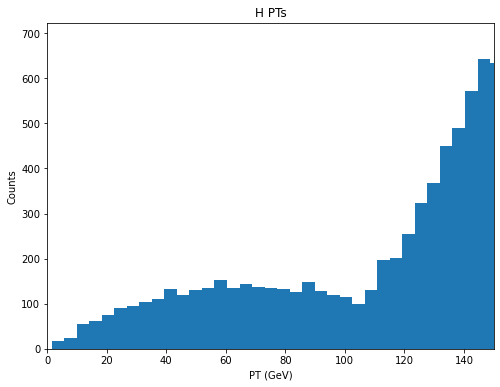

In [6]:
def H_PT(H_data): 
    #mean = H_data['Particle.PT'].mean()
    #std = H_data['Particle.PT'].std()
    nbins = 300 
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    #plt.hist(H_data['Particle.PT'], bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.hist(H_data['Particle.PT'], bins=nbins)
    plt.title(f'H PTs')
    plt.xlabel(f'PT (GeV)')
    plt.ylabel(f'Counts')
    plt.xlim((0,150))

H_data = data[(data['Particle.PID'] == 35)]

H_PT(H_data)

This is just the sum of the individual PTs, not the actual total PT_miss that will be measured -> need to combine the PT of all the inert scalars, start by doing this just for h2 then include the h3 

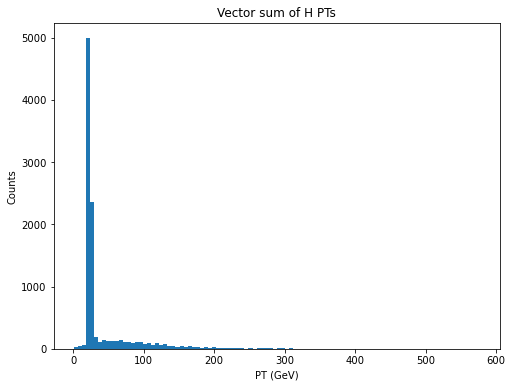

In [7]:

def H_PT_vectorSum(H_data):
    grouped = H_data.groupby(level=0).sum()
    grouped['PT_tot'] = np.sqrt(grouped['Particle.Px']**2 + grouped['Particle.Py']**2)
    nbins = 100
    #mean = grouped['PT_tot'].mean()
    #std = grouped['PT_tot'].std()
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    #plt.hist(grouped['PT_tot'], bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.hist(grouped['PT_tot'], bins=nbins)
    plt.title(f'Vector sum of H PTs')
    plt.xlabel(f'PT (GeV)')
    plt.ylabel(f'Counts')


H_PT_vectorSum(H_data)

-> The h2s like to go in opposite directions

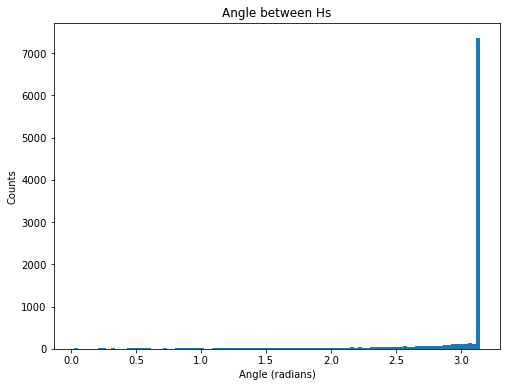

In [11]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def getAngle(df):
    vs = df[['Particle.Px', 'Particle.Py', 'Particle.Pz']].to_numpy()
    angle = angle_between(vs[0,:2], vs[1,:2])
    return angle

def angleDiff(H_data):
    g = H_data.groupby('entry')
    angles = g.apply(getAngle)
    #mean = np.mean(angles)
    #std = np.std(angles)
    nbins = 100
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    #plt.hist(angles, bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.hist(angles, bins=nbins)
    plt.title(f'Angle between Hs')
    plt.xlabel(f'Angle (radians)')
    plt.ylabel(f'Counts')

angleDiff(H_data)

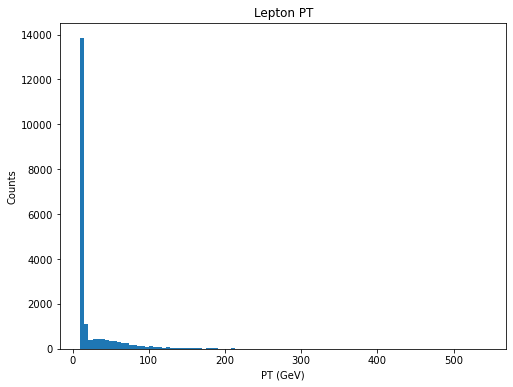

In [9]:
# Let's do some plots for the leptons

def lepton_PT(lepton_data):
    #mean = lepton_data['Particle.PT'].mean()
    #std = lepton_data['Particle.PT'].std()
    nbins = 100
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    #plt.hist(lepton_data['Particle.PT'], bins=nbins, label=f'$\mu={mean:0.2f}$, $\sigma={std:0.2f}$')
    plt.hist(lepton_data['Particle.PT'], bins=nbins)
    plt.title(f'Lepton PT')
    plt.xlabel(f'PT (GeV)')
    plt.ylabel(f'Counts')



lepton_data = data[(abs(data['Particle.PID']) == 11) | (abs(data['Particle.PID']) == 13)]

lepton_PT(lepton_data)


51.207983614546606


Text(0.5, 0, 'E (GeV)')

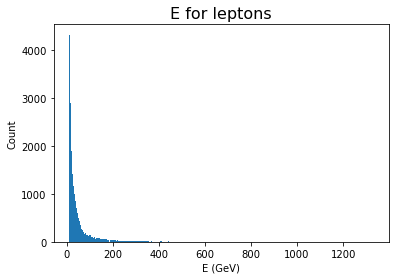

In [10]:
# Lepton energy
print(lepton_data['Particle.E'].mean())
nbins = 300
n, bins, patches = plt.hist(lepton_data['Particle.E'], bins=nbins)
plt.title(f'E for leptons', fontsize=16)
plt.ylabel('Count')
plt.xlabel('E (GeV)')
#plt.xlim((0,500))

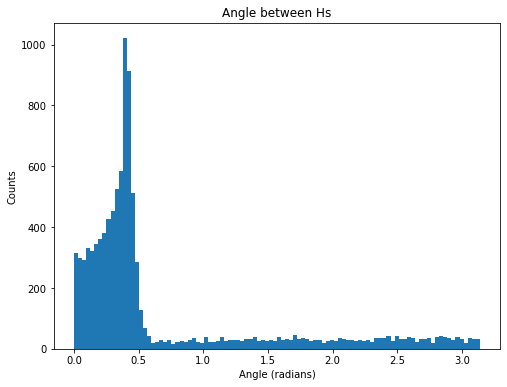

In [12]:
# Angle between the two leptons
angleDiff(lepton_data)

Text(0.5, 1.0, 'Jet PT')

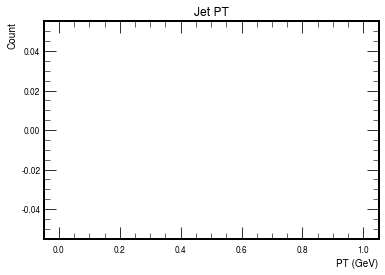

In [96]:
# Let's look at the jets now
# First get rid of the particles that are travelling
# down the beam pipe (e.g. a u with eta=999)
signal_data = data[(abs(data['Particle.Eta']) < 998)]
# Now pick out the quarksoth the signal and the background, which typically has a much larger size, involve leptons com
quarks = [1,2,3,4,5]
signal_data = signal_data[abs(signal_data['Particle.PID']).isin(quarks)]

# Plot of PT
nbins = 50
n, bins, patches = plt.hist(signal_data['Particle.PT'], bins=nbins)
plt.xlabel('PT (GeV)')
plt.ylabel('Count')
plt.title('Jet PT')

Text(0.5, 1.0, 'Jet Eta')

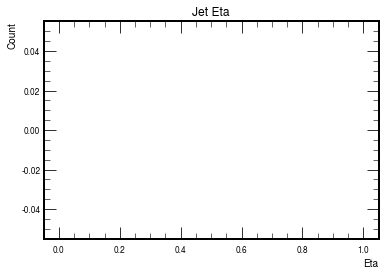

In [97]:
# Plot of jet eta
nbins = 50
n, bins, patches = plt.hist(signal_data['Particle.Eta'], bins=nbins)
plt.xlabel('Eta')
plt.ylabel('Count')
plt.title('Jet Eta')

In [ ]:
file = uproot.open('/vols/cms/emc21/idmStudy/MadGraph_files/distributions/h2h2lPlM_lem/BP1/h2h2lPlM_lem_BP1/Events/run_01/unweighted_events.root')
tree = file['LHEF']
tree = tree['Particle']
print(tree.keys())
data = tree.arrays(['Particle.PID', 'Particle.Px','Particle.Py', 'Particle.Pz', 'Particle.PT', 'Particle.E', 'Particle.Eta', 'Particle.Status'], library='ak')


def findPT(px, py):
    total_px = ak.sum(px, axis=1)
    total_py = ak.sum(py, axis=1)
    return np.sqrt(total_px**2 + total_py**2)

# Finding PT of the two Hs
H_data = final[final['Particle.PID'] == 35][:1]
px = H_data['Particle.Px']
py = H_data['Particle.Py']
print(f'Combined PT of the two Hs = {findPT(px, py)}')

lepton_data = final[(abs(final['Particle.PID']) == 11) | (abs(final['Particle.PID']) == 13)][:1]
px = lepton_data['Particle.Px']
py = lepton_data['Particle.Py']
print(f'Combined PT of the two leptons = {findPT(px, py)}')

input_line_128:1:10: fatal error: '/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeReader.h' file not found
#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeReader.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_line_129:1:10: fatal error: '/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeBranch.h' file not found
#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeBranch.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Warning in <TCanvas::Constructor>: Deleting canvas with same name: myc


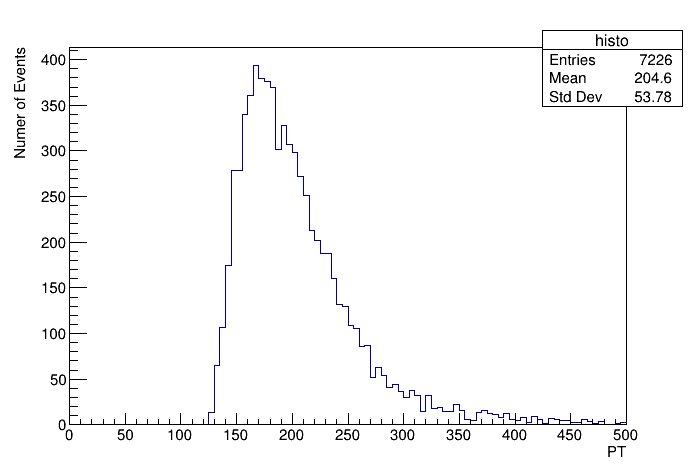

In [20]:
import ROOT

# ROOT.gSystem.Load("/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/libExRootAnalysis.so")
ROOT.gInterpreter.Declare('#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/vols/cms/emc21/FCC/MG5_aMC_v2_6_7/ExRootAnalysis/ExRootAnalysis/ExRootTreeBranch.h"')

# p p > h2 h2 l+ l-
# This reads in the file
inFile = ROOT.TFile.Open("/vols/cms/emc21/idmStudy/MadGraph_files/distributions/h2h2lPlM_lem/BP2/h2h2lPlM_lem_BP2/Events/run_01/unweighted_events.root")
# This get's the tree from the file
# The argument LHEF is the name of the tree -> Can be found by the root gui file thing
tree = inFile.Get("LHEF")

histo = ROOT.TH1F("histo", ";PT; Numer of Events", 100, 0, 500)
#tree.Draw("Particle.E>>histo", "Particle.PID == 35 && Particle.Eta > -1 && Particle.Eta < 1")
tree.Draw("Particle.PT>>histo", "Particle.PID == 36")
myc = ROOT.TCanvas("myc","myc",1)
myc.cd()
histo.Draw()
myc.Draw()
# Why are there so many Z bosons in the final state as well? Something to ask AM.